# 1. Import libraries

In [1]:
from __future__ import print_function, division

import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist

# 2. Download the dataset and preprocess

In [2]:
(training_data, _), (_, _) = fashion_mnist.load_data()

In [3]:
# Rescale training data to scale -1 to 1
X_train = training_data / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

# 3. Visualize the image matrix

In [4]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    img_thresh = img.max() / 2.5

    for x in range(width):
        for y in range(height):
            ax.annotate(f"{round(img[x][y], 2)}", xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y] < img_thresh else 'black')

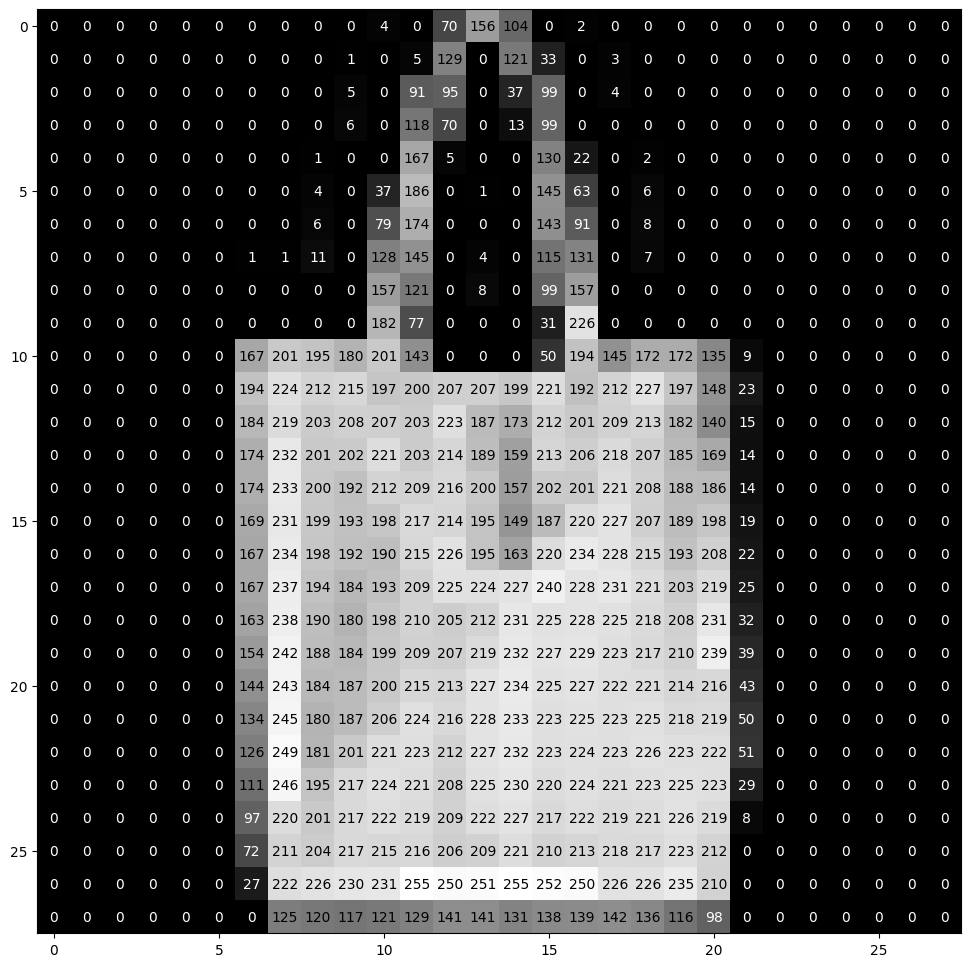

In [5]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
visualize_input(training_data[3343], ax)

# 4. Build the combined model (generator + discriminator)

In [6]:
from generator import build_generator
from discriminator import build_discriminator

from keras.optimizers.legacy import Adam
from keras.layers import Input
from keras.models import Model

In [7]:
# Define the optimizer
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build generator
generator = build_generator()

# The generator takes noise as input and generates images
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator, freeze the discriminator's weights
discriminator.trainable = False

# Discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model (stacked generator and discriminator)
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d (ZeroPaddin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 8, 8, 64)          256       
 Normalization)                                         

# 5. Build the training function

In [8]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, 100])

    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"images/gan_generated_image_epoch_{epoch}.png")
    plt.close()

In [9]:
def train(epochs, batch_size=128, print_interval=20, save_interval=50):
    # Adversarial ground truth
    valid = np.ones(shape=(batch_size, 1))
    fake = np.zeros(shape=(batch_size, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real - 1s; generated/fake - 0s)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator - wants the discriminator to mistake images for real ones
        g_loss = combined.train_on_batch(noise, valid)

        # Print progress
        if epoch % print_interval == 0:
            print(f"[Epoch: {epoch}]: D loss: {d_loss[0]}; Acc: {100 * d_loss[0]}; G loss: {g_loss}")

        # Save generated image samples at save_interval
        if epoch % save_interval == 0:
            plot_generated_images(epoch, generator)

# 6. Train the model and observe the results

In [10]:
train(epochs=10000, batch_size=32, print_interval=200, save_interval=500)

1/1 [==============================] - 0s 59ms/step
[Epoch: 0]: D loss: 1.0184269845485687; Acc: 101.84269845485687; G loss: 0.6991764307022095
1/1 [==============================] - 0s 19ms/step
[Epoch: 200]: D loss: 0.001276717201108113; Acc: 0.1276717201108113; G loss: 0.14361506700515747
1/1 [==============================] - 0s 20ms/step
[Epoch: 400]: D loss: 0.0003380003327038139; Acc: 0.03380003327038139; G loss: 0.07853388041257858
1/1 [==============================] - 0s 21ms/step
[Epoch: 600]: D loss: 0.0020248781293048523; Acc: 0.20248781293048523; G loss: 0.19195091724395752
1/1 [==============================] - 0s 21ms/step
[Epoch: 800]: D loss: 0.001397533455019584; Acc: 0.1397533455019584; G loss: 0.0816303938627243
1/1 [==============================] - 0s 21ms/step
[Epoch: 1000]: D loss: 9.54844981606584e-05; Acc: 0.00954844981606584; G loss: 0.03768644854426384
1/1 [==============================] - 0s 21ms/step
[Epoch: 1200]: D loss: 0.00046189025306375697; Acc: 0.